# Example: CR3BP filtering with angles only measurements

2024.10.29, Malav Patel and Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append('../')
import rudolfpy as rd
from rudolfpy import _get_state_history_filter, plot_state_history

/opt/homebrew/Caskroom/miniconda/base/envs/rd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## ground truth initial conditions for targets and observers
groundtruth_targets = np.array([
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ])

# CR3BP dynamics parameters
mu = 1.215058560962404e-02
LU = 384400
TU = 3.751902619517228e+05
VU = LU / TU

# positional uncertainty (is used to compute initial covariance of target and observer state)
sigma_r0 = 100 / LU
sigma_v0 = 0.001 / VU

# measurement model uncertainty in angle measurement
sigma_phi = np.deg2rad(0.1)
# measurement model time of exposure for sensor measurement
dt_meas = 3600/TU

# estimates for (x0, P0) for observer and targets
estimate_targets = groundtruth_targets + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)
P0_targets = np.diag([sigma_r0]*3 + [sigma_v0]*3)**2


# create dynamics model
dynamics = rd.DynamicsCR3BP(mu = mu, LU=LU, TU=TU, method='DOP853', rtol = 1e-12, atol = 1e-12)
# create measurement model
meas_model = rd.MeasurementAngleAngleRate()
# process noise
params_Q = [1e-2,]
# create EKF object
filter = rd.UnscentedKalmanFilter(dynamics, meas_model,
                                 func_process_noise = rd.unbiased_random_process_3dof,
                                 params_Q = params_Q)
# timestep of simulation
timestep = 0.015


In [3]:
t_measurements = np.linspace(0.05, 3.225, 10)
t_eval = np.linspace(0, 3.225, 100)
x_observer = [1.0 - mu, 0, 0, 0, 0, 0]
params_measurements = [[x_observer, sigma_phi, dt_meas]]*t_measurements.size

In [4]:
target_history = _get_state_history_filter(filter, estimate_targets, P0_targets, groundtruth_targets,t_eval, t_measurements, params_measurements)

(<Figure size 1200x600 with 6 Axes>,
 array([[<Axes: xlabel='Time, TU', ylabel='$x$, km'>,
         <Axes: xlabel='Time, TU', ylabel='$y$, km'>,
         <Axes: xlabel='Time, TU', ylabel='$z$, km'>],
        [<Axes: xlabel='Time, TU', ylabel='$v_x$, m/s'>,
         <Axes: xlabel='Time, TU', ylabel='$v_y$, m/s'>,
         <Axes: xlabel='Time, TU', ylabel='$v_z$, m/s'>]], dtype=object))

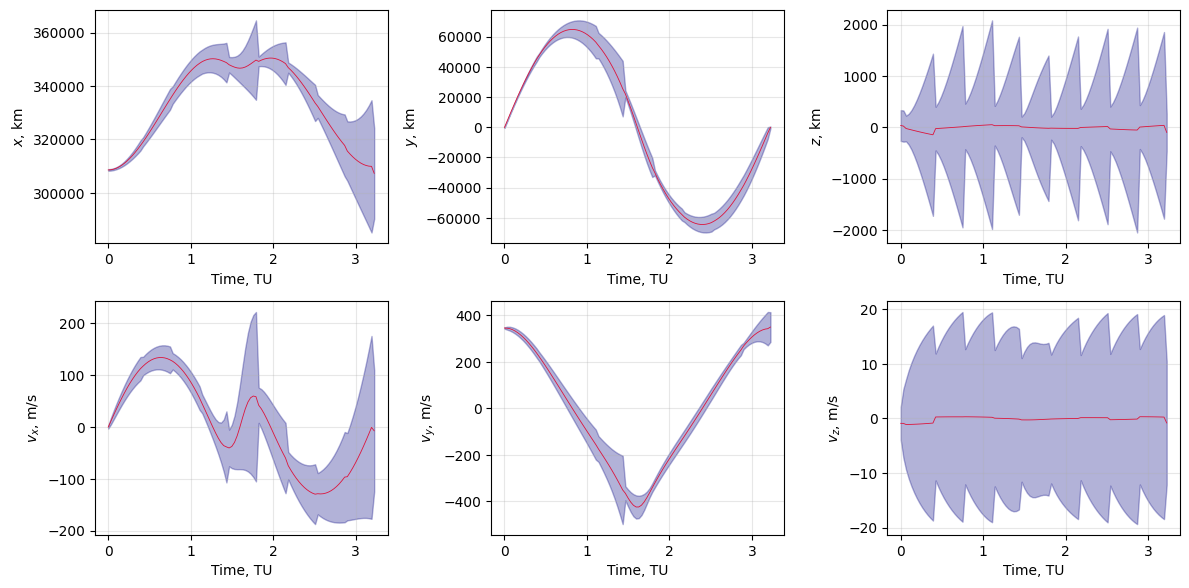

In [5]:
plot_state_history(
        target_history,
        k_sigma = 3,
        figsize = (12,6),
        lw_estimate = 0.6,
        color_estimate = "crimson",
        color_true = "black",
        color_sigma = "navy",
        alpha_sigma = 0.3,
        TU = 1.0,
        state_multipliers = [LU,LU,LU,1e3*VU,1e3*VU,1e3*VU],
        state_labels = ["$x$, km","$y$, km","$z$, km",
                    "$v_x$, m/s","$v_y$, m/s","$v_z$, m/s"],
        time_unit = "TU",
    )

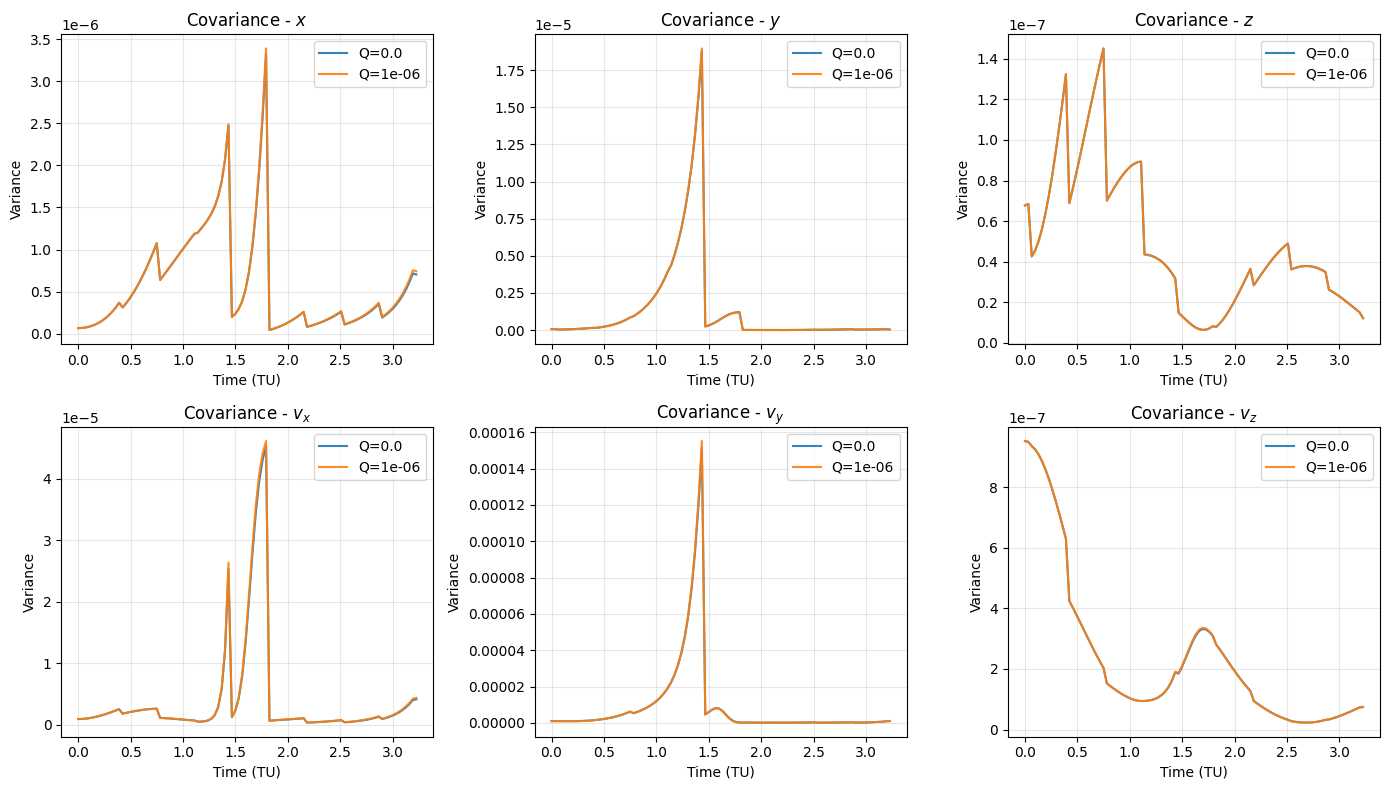

In [7]:
# Run UKF for Q=0 and Q=1e-7 and overlay covariance plots
Q_values = [0.0, 1e-6]
colors = ['tab:blue', 'tab:orange']
labels = [f"Q={Q}" for Q in Q_values]

histories = []
for Q in Q_values:
    ukf = rd.UnscentedKalmanFilter(dynamics, meas_model,
                                   func_process_noise=rd.unbiased_random_process_3dof,
                                   params_Q=[Q])
    histories.append(_get_state_history_filter(ukf, estimate_targets, P0_targets, groundtruth_targets,
                                               t_eval, t_measurements, params_measurements))

# extract times (same for all) and plot
times = np.array([entry[2] for entry in histories[0]])
fig_q, axes_q = plt.subplots(2, 3, figsize=(14, 8))
axes_q = axes_q.flatten()
state_labels_short = ["$x$", "$y$", "$z$", "$v_x$", "$v_y$", "$v_z$"]

for idx, (Q, hist, color, label) in enumerate(zip(Q_values, histories, colors, labels)):
    P_diags = np.array([np.diag(entry[1]) for entry in hist])
    for i in range(6):
        axes_q[i].plot(times, P_diags[:, i], color=color, label=label if idx == 0 or idx == 1 else None, linewidth=1.5, alpha=0.9)

for i in range(6):
    axes_q[i].set_xlabel('Time (TU)')
    axes_q[i].set_ylabel('Variance')
    axes_q[i].set_title(f'Covariance - {state_labels_short[i]}')
    axes_q[i].grid(True, alpha=0.3)
    axes_q[i].legend()

plt.tight_layout()
plt.show()